# Importer les données

In [5]:
!kaggle competitions download -c spaceship-titanic


  0%|          | 0.00/299k [00:00<?, ?B/s]
100%|##########| 299k/299k [00:00<00:00, 998kB/s]
100%|##########| 299k/299k [00:00<00:00, 998kB/s]


In [7]:
!tar  -xf spaceship-titanic.zip

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps
import sklearn
dataset = pd.read_csv("train.csv", index_col=0)
dataset

/home/matthias/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True


## Explorer le Dataset, regarder les valeurs manquantes

In [4]:
dataset[dataset['Cabin'].isna()] # voir quelles lignes ont un nan à la colonne 'Cabin'
dataset.iloc[[15]] # accéder à une ligne
dataset.loc["0012_01"]["Cabin"]
# regarder les valeurs prises par une colonne
dataset["VIP"].unique()

array([False, True, nan], dtype=object)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 1.1+ MB


In [6]:
# regarder les premières corrélations
dataset.corr()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


## Créer la colonne prédite: `Transported`

In [7]:
train_labels = dataset.loc[:,"Transported"]

## Créer un nouveau dataset retravaillé `reduced_dataset`
### Supprimer les données non pertinentes évidentes et remplacer les booléens par des nombres

In [8]:
reduced_dataset = dataset.copy(deep=True)
reduced_dataset.drop(["Name", "HomePlanet", "Destination"], axis=1, inplace=True)
reduced_dataset.replace({False:0.0,True:1.0}, inplace=True)
# on peut supposer que la collision ayant eu lieu pendant le voyage lors du naufrage, ces données n'ont aucune importance
# l'âge semble n'avoir que peu d'importance mais il semble que les plus jeunes (enfants) aient été transportés
reduced_dataset.isnull().sum()

CryoSleep       217
Cabin           199
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

### Scinder la colonne `Cabin` textuelle en trois catégories deck, number, side

In [9]:
# ma solution, non robustes aux données manquantes
def scinder_deck(df):
    val_cab = df.loc[:, "Cabin"].values
    index = df.index
    decks = []
    nums = []
    sides = []
    for cabin in val_cab:
        match = regex.search(r'([A-Z])\/([0-9]*)\/([PS])', cabin) # problème si c'est un Nan, ne fonctionne que si on élimine les lignes problématiques
        deck = match.group(1)
        num  = match.group(2)
        side = match.group(3)
        decks.append(deck)
        nums.append(int(num))
        sides.append(True if side=='P' else False) # car seulement deux côtés
    assert len(decks) == len(df.index)
    df["Cabin_Deck"] = decks
    df["Cabin_Num"]  = nums
    df["Cabin_Side"] = sides
# scinder_deck(reduced_dataset)

In [10]:
reduced_dataset[['CabinDeck', 'CabinNumber','CabinSide']] = reduced_dataset['Cabin'].str.split('/', expand=True) # solution trouvée sur le notebook en exemple
reduced_dataset.drop(["Cabin"], axis=1, inplace=True) # supprimer ensuite la colonne inutile désormais

In [11]:
reduced_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CryoSleep     8476 non-null   float64
 1   Age           8514 non-null   float64
 2   VIP           8490 non-null   float64
 3   RoomService   8512 non-null   float64
 4   FoodCourt     8510 non-null   float64
 5   ShoppingMall  8485 non-null   float64
 6   Spa           8510 non-null   float64
 7   VRDeck        8505 non-null   float64
 8   Transported   8693 non-null   float64
 9   CabinDeck     8494 non-null   object 
 10  CabinNumber   8494 non-null   object 
 11  CabinSide     8494 non-null   object 
dtypes: float64(9), object(3)
memory usage: 1.1+ MB


### Nettoyer les données manquantes en paddant

In [12]:
print(f"There are NaN values in the dataset: {reduced_dataset.isna().values.any()}")
n_col = len(reduced_dataset.columns)
# input_train = pd.DataFrame.dropna(input_train, axis='index')
reduced_dataset.fillna(inplace=True, axis=0, method='pad')

# je choisir de faire un pad car si je choisis la méthode qui vire toutes les lignes contenant des nan, les types des colonnes ne sont pas ramenés à leur unique valeur (i.e. sont labellées comme objects et non bool par exemple)

There are NaN values in the dataset: True


### Nouvelle visualisation avec les features retravaillées

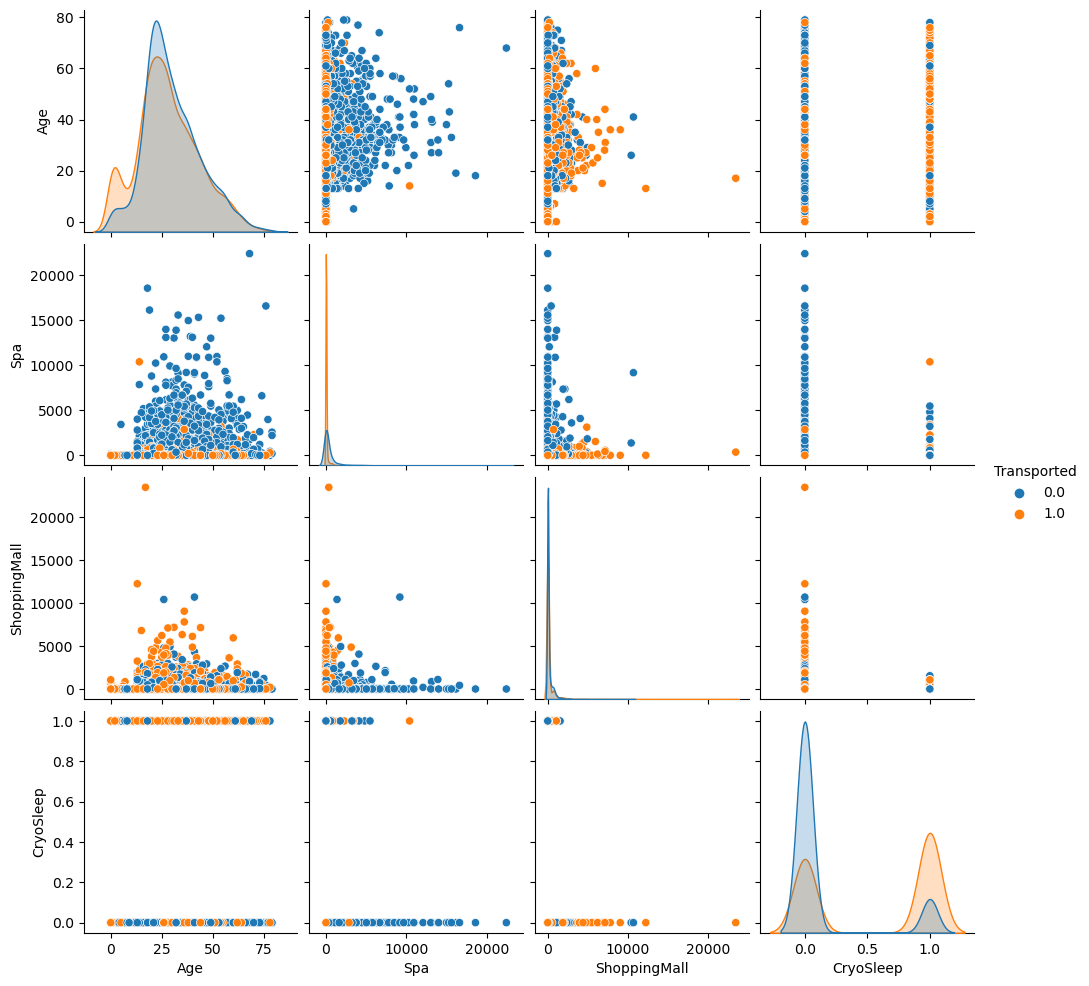

In [91]:
g = sns.pairplot(reduced_dataset[["Age", "Spa", "ShoppingMall", "CryoSleep", "Transported"]], hue="Transported")

<AxesSubplot:xlabel='Age', ylabel='Density'>

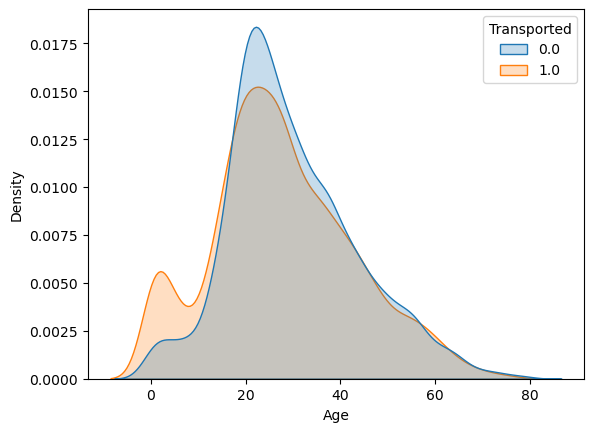

In [57]:
sns.kdeplot(data=reduced_dataset, x="Age", hue="Transported", fill=True)

<AxesSubplot:xlabel='CryoSleep', ylabel='Density'>

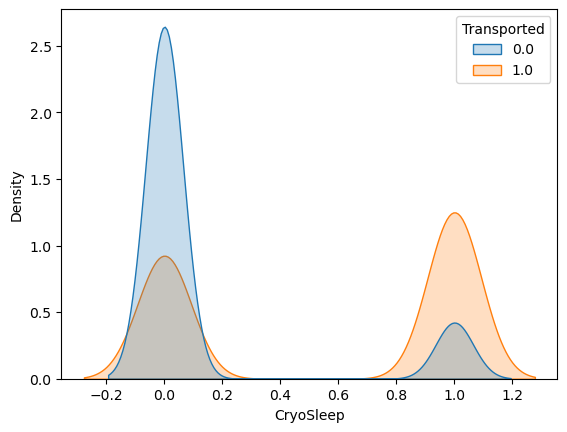

In [77]:
sns.kdeplot(data=reduced_dataset, x="CryoSleep", hue="Transported", fill=True)

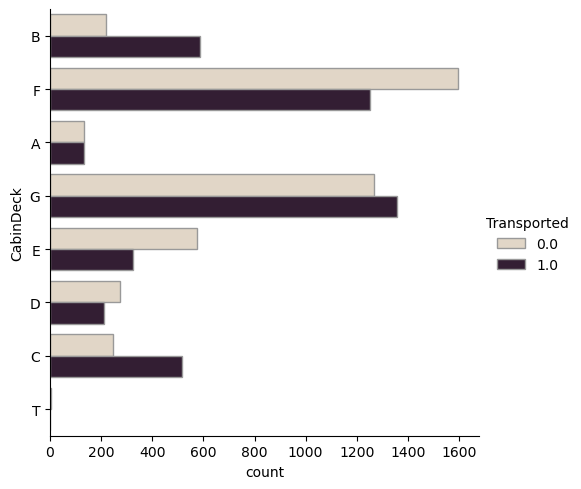

In [92]:
sns.catplot(
    data=reduced_dataset, y="CabinDeck", hue="Transported", kind="count",
    palette="ch:.25", edgecolor=".6",
)

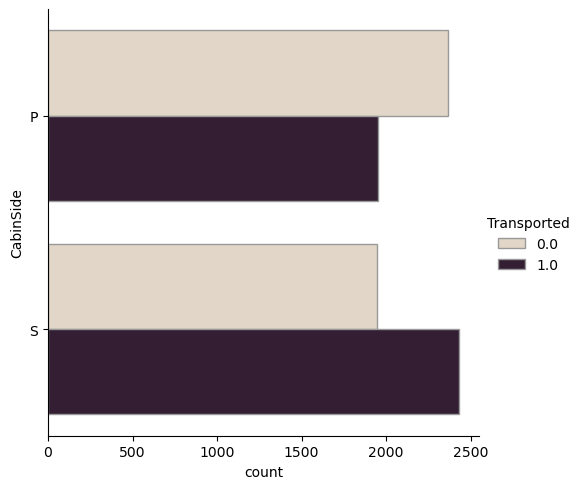

In [94]:
sns.catplot(
    data=reduced_dataset, y="CabinSide", hue="Transported", kind="count",
    palette="ch:.25", edgecolor=".6",
)

### Nouvelle matrice de corrélation

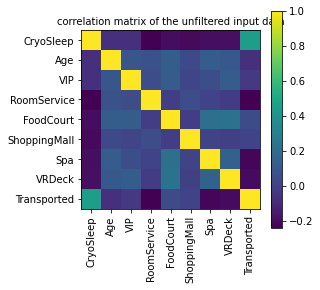

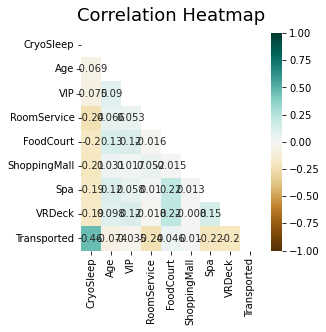

In [14]:
dataset_correlation = reduced_dataset
correlation_set = pd.get_dummies(reduced_dataset.drop(labels=['CabinDeck', 'CabinNumber','CabinSide'], axis=1)) 


mat_corr = correlation_set.corr()
labels = list(mat_corr.index)
mat_corr_np = np.array(mat_corr)

plt.figure(figsize = (4, 4))
plt.imshow(mat_corr_np, cmap='viridis')
plt.colorbar()
plt.xticks(range(len(mat_corr.index)), labels, rotation='vertical', fontsize=10)
plt.yticks(range(len(mat_corr.index)), labels, rotation='horizontal', fontsize=10)
plt.title('correlation matrix of the unfiltered input data', size=10)
plt.show()



plt.figure(figsize=(4, 4))
mask = np.triu(np.ones_like(mat_corr, dtype=bool))
heatmap = sns.heatmap(mat_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG', mask=mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

## Numériser les features categorical des chambres par un one-hot encoding

In [105]:
amenities_features = reduced_dataset.loc[:, ['FoodCourt', 'ShoppingMall', 'Spa', 'RoomService', 'VRDeck']]
amenities_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FoodCourt     8693 non-null   float64
 1   ShoppingMall  8693 non-null   float64
 2   Spa           8693 non-null   float64
 3   RoomService   8693 non-null   float64
 4   VRDeck        8693 non-null   float64
dtypes: float64(5)
memory usage: 665.5+ KB


In [16]:
cabin_features = pd.get_dummies(reduced_dataset.loc[:, ['CabinDeck', 'CabinSide']])
cabin_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   CabinDeck_A  8693 non-null   uint8
 1   CabinDeck_B  8693 non-null   uint8
 2   CabinDeck_C  8693 non-null   uint8
 3   CabinDeck_D  8693 non-null   uint8
 4   CabinDeck_E  8693 non-null   uint8
 5   CabinDeck_F  8693 non-null   uint8
 6   CabinDeck_G  8693 non-null   uint8
 7   CabinDeck_T  8693 non-null   uint8
 8   CabinSide_P  8693 non-null   uint8
 9   CabinSide_S  8693 non-null   uint8
dtypes: uint8(10)
memory usage: 410.8+ KB


In [106]:
cabin_data = cabin_features.values.astype('float32')
cabin_data.shape

amenities_data = amenities_features.values.astype('float32')
amenities_data.shape

(8693, 5)

### Autoencodeur polyvalent pour cabines

In [112]:
import tensorflow as tf

class Autoencoder(tf.keras.models.Model):
    def __init__(self, latent_dim, nor_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(latent_dim, activation='sigmoid')
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(nor_dim, activation='relu'),
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [117]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.005
)
autoencoder = Autoencoder(latent_dim=5, nor_dim=10)
autoencoder.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())

autoencoder.build(input_shape=(None,10))
autoencoder.summary()

Model: "autoencoder_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_28 (Sequential)   (None, 5)                 55        
_________________________________________________________________
sequential_29 (Sequential)   (None, 10)                60        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________


In [102]:
data_train = np.random.randint(low=0, high=2, size=(10000,5))

In [ ]:
autoencoder.fit(data_train, data_train,
                epochs=20,
                shuffle=True,
                validation_data=(data_train, data_train))

In [118]:
path = "./autoencoder_bin_vec10bits.ckpt"
# autoencoder.save_weights(path)
autoencoder.load_weights(path)


### Tests sur le dataset et des exemples

In [119]:
autoencoder.evaluate(
    x=cabin_data,
    y=cabin_data
)

272/272 [==============================] - 0s 650us/step - loss: 0.1555


0.15551486611366272

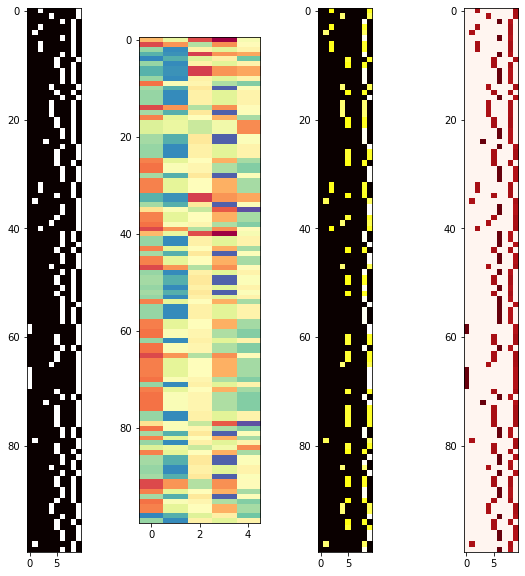

In [120]:
input_test = cabin_data[1500:1600,:]
encoded = autoencoder.encoder.predict(input_test)
decoded = autoencoder.decoder.predict(encoded)
# np.round(decoded, decimals = 2, out = None)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
ax1.imshow(input_test, cmap='hot', interpolation='nearest')
ax2.imshow(encoded, cmap='Spectral', aspect=.2)
ax3.imshow(decoded, cmap='hot', interpolation='nearest')
ax4.imshow(input_test-decoded, cmap='Reds', interpolation='nearest')

In [121]:
r = np.array([[1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
              [0, 0, 1, 1, 1, 1, 0, 0, 1, 0]])
np.round(autoencoder.decoder(autoencoder.encoder.predict(r)).numpy(), decimals=2)


array([[0.  , 0.  , 0.09, 0.  , 0.09, 0.  , 0.  , 0.  , 0.09, 0.09],
       [0.  , 0.  , 0.07, 0.  , 0.07, 0.08, 0.  , 0.  , 0.07, 0.  ]],
      dtype=float32)

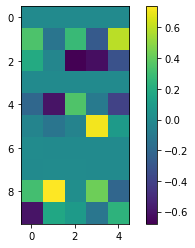

In [78]:
weights_w = autoencoder.encoder.layers[0].weights[0]
weights_b = autoencoder.encoder.layers[0].weights[1]
fig, ax = plt.subplots()
shw = ax.imshow(weights_w, cmap='viridis')
bar = plt.colorbar(shw)

### Calculer les encodages de chaque passager pour la localisation de leur chambre

In [79]:
encoded_cabin_data = autoencoder.encoder.predict(cabin_data)
cabins_repr_dataset = pd.DataFrame(encoded_cabin_data, columns=['cab1', 'cab2', 'cab3', 'cab4', 'cab5']) 
cabins_repr_dataset.index = reduced_dataset.index

In [ ]:
pca2 = sklearn.decomposition.PCA(n_components=2)
pca2.fit(encoded_cabin_data)
applied_cabin_data = pca2.transform(encoded_cabin_data)
plt.scatter(applied_cabin_data[:,0], applied_cabin_data[:,1])

### Remplacer les colonnes `CabinDeck`, `CabinNumber` et `CabinSid` par leur encodage dans le `encoded_dataset`

In [80]:
encoded_dataset = pd.concat([reduced_dataset, cabins_repr_dataset], axis=1)
encoded_dataset.drop(["CabinDeck", "CabinSide", "CabinNumber"], axis=1, inplace=True)
encoded_dataset

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cab1,cab2,cab3,cab4,cab5
PassengerId,,,,,,,,,,,,,,
0001_01,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.676772,0.644249,0.544155,0.472558,0.623118
0002_01,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0.362513,0.504782,0.480214,0.581870,0.610504
0003_01,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0.371932,0.537458,0.491800,0.405953,0.588666
0003_02,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0.371932,0.537458,0.491800,0.405953,0.588666
0004_01,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0.362513,0.504782,0.480214,0.581870,0.610504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,0.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0.0,0.598211,0.673646,0.474107,0.541741,0.477857
9278_01,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.372502,0.536915,0.492133,0.405864,0.588078
9279_01,0.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1.0,0.372502,0.536915,0.492133,0.405864,0.588078


### Rescaling pour les amenities et remplacement dans le dataset encodé

In [131]:
scaler = sklearn.preprocessing.MinMaxScaler()
amenities_features = scaler.fit_transform(amenities_features)
encoded_dataset[['FoodCourt', 'ShoppingMall', 'Spa', 'RoomService', 'VRDeck']] = amenities_features
encoded_dataset

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cab1,cab2,cab3,cab4,cab5
PassengerId,,,,,,,,,,,,,,
0001_01,0.0,39.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.676772,0.644249,0.544155,0.472558,0.623118
0002_01,0.0,24.0,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,1.0,0.362513,0.504782,0.480214,0.581870,0.610504
0003_01,0.0,58.0,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.0,0.371932,0.537458,0.491800,0.405953,0.588666
0003_02,0.0,33.0,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.0,0.371932,0.537458,0.491800,0.405953,0.588666
0004_01,0.0,16.0,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,1.0,0.362513,0.504782,0.480214,0.581870,0.610504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,0.0,41.0,1.0,0.000000,0.228726,0.000000,0.073322,0.003066,0.0,0.598211,0.673646,0.474107,0.541741,0.477857
9278_01,1.0,18.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.372502,0.536915,0.492133,0.405864,0.588078
9279_01,0.0,26.0,0.0,0.000000,0.000000,0.079687,0.000045,0.000000,1.0,0.372502,0.536915,0.492133,0.405864,0.588078


## Réaffichage des matrices de corrélation avec PPscore (https://github.com/8080labs/ppscore)

<AxesSubplot:xlabel='x', ylabel='y'>

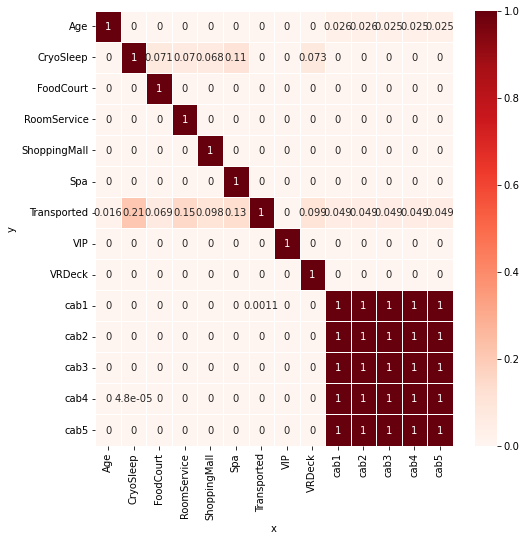

In [137]:
# calculer la matrice de covariance des ppscore
pps_corr_matrix = pps.matrix(encoded_dataset)
matrix_df = pps_corr_matrix[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Reds", linewidths=0.5, annot=True, ax=ax) # sens: x predicting y

C'est intéressant car on voit que nos paramètres tous harmonisés entre 0 et 1 ont maintenant tous une chance de prédire un peu la variable "Transported", particulièrement l'encodage de la cabine. C'est un indicateur prometteur.

In [138]:
# calculer l'influence de tous les prédicteurs sur une variable d'observation
pps.predictors(encoded_dataset, "Transported")

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,CryoSleep,Transported,0.208153,regression,True,mean absolute error,0.4966,0.393231,DecisionTreeRegressor()
1,RoomService,Transported,0.150615,regression,True,mean absolute error,0.4966,0.421804,DecisionTreeRegressor()
2,Spa,Transported,0.132173,regression,True,mean absolute error,0.4966,0.430963,DecisionTreeRegressor()
3,VRDeck,Transported,0.099217,regression,True,mean absolute error,0.4966,0.447329,DecisionTreeRegressor()
4,ShoppingMall,Transported,0.097892,regression,True,mean absolute error,0.4966,0.447987,DecisionTreeRegressor()
5,FoodCourt,Transported,0.068809,regression,True,mean absolute error,0.4966,0.462429,DecisionTreeRegressor()
6,cab1,Transported,0.049131,regression,True,mean absolute error,0.4966,0.472201,DecisionTreeRegressor()
7,cab3,Transported,0.049101,regression,True,mean absolute error,0.4966,0.472217,DecisionTreeRegressor()
8,cab4,Transported,0.049101,regression,True,mean absolute error,0.4966,0.472217,DecisionTreeRegressor()
9,cab5,Transported,0.049101,regression,True,mean absolute error,0.4966,0.472217,DecisionTreeRegressor()


In [139]:
# calculer l'influence d'un predicteur
pps.score(reduced_dataset, "CryoSleep", "Transported")

{'x': 'CryoSleep',
 'y': 'Transported',
 'ppscore': 0.20815334741234826,
 'case': 'regression',
 'is_valid_score': True,
 'metric': 'mean absolute error',
 'baseline_score': 0.4966,
 'model_score': 0.39323104767502787,
 'model': DecisionTreeRegressor()}

# Utiliser des RandomForests et XGBoost
## Fitting RandomForest

In [14]:
from sklearn.ensemble import RandomForestClassifier
N_est = 1000
rfc = RandomForestClassifier(n_estimators = N_est, random_state = 42)

In [15]:
rfc.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=1000, random_state=42)

## Fitting XGBoost

In [593]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(train_features, train_labels)

GradientBoostingClassifier()

## Fitting SVM

In [79]:
from sklearn import svm
svc = svm.SVC(kernel='poly', degree=3)
svc.fit(train_features, train_labels)
# svr = svm.SVR() # regression donc non
# svr.fit(train_features, train_labels)

SVC(kernel='poly')

## Importer le test set

In [17]:
input_test = pd.read_csv("test.csv", index_col=0)
input_test.info(verbose=True)
input_test.isna().values.any()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0013_01 to 9277_01
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4190 non-null   object 
 1   CryoSleep     4184 non-null   object 
 2   Cabin         4177 non-null   object 
 3   Destination   4185 non-null   object 
 4   Age           4186 non-null   float64
 5   VIP           4184 non-null   object 
 6   RoomService   4195 non-null   float64
 7   FoodCourt     4171 non-null   float64
 8   ShoppingMall  4179 non-null   float64
 9   Spa           4176 non-null   float64
 10  VRDeck        4197 non-null   float64
 11  Name          4183 non-null   object 
dtypes: float64(6), object(6)
memory usage: 434.4+ KB


True

## Nettoyer le test set

In [18]:
input_test.fillna(inplace=True, axis=0, method='pad')
# input_test.info(verbose=True)
# input_test.isna().any()

## Retraiter les données de cabine sur le test set

In [19]:
scinder_deck(input_test)

In [20]:
test_features = pd.get_dummies(input_test.drop(labels=['Name', 'Cabin'], axis=1))
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0013_01 to 9277_01
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  4277 non-null   bool   
 1   Age                        4277 non-null   float64
 2   VIP                        4277 non-null   bool   
 3   RoomService                4277 non-null   float64
 4   FoodCourt                  4277 non-null   float64
 5   ShoppingMall               4277 non-null   float64
 6   Spa                        4277 non-null   float64
 7   VRDeck                     4277 non-null   float64
 8   Cabin_Num                  4277 non-null   int64  
 9   Cabin_Side                 4277 non-null   bool   
 10  HomePlanet_Earth           4277 non-null   uint8  
 11  HomePlanet_Europa          4277 non-null   uint8  
 12  HomePlanet_Mars            4277 non-null   uint8  
 13  Destination_55 Cancri e    4277 non-null   u

## Predict & Submit les RandomForest, XGBoost, SVM

In [84]:
predict = pd.DataFrame(svc.predict(test_features), index=input_test.index, columns=["Transported"])
predict

,Transported
PassengerId,
0013_01,True
0018_01,True
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,True
9271_01,True


In [85]:
predict.to_csv("./predict.csv")

In [86]:
!kaggle competitions submit -c spaceship-titanic -f "predict.csv" -m "SVR_sklearn"

^C
Successfully submitted to Spaceship Titanic



  0%|          | 0.00/59.4k [00:00<?, ?B/s]
100%|##########| 59.4k/59.4k [00:01<00:00, 42.0kB/s]


# Utiliser un réseau neuronal
## Création des colonnes `train_features_nn`, conversion en `float32`

In [21]:
train_features_nn = train_features.copy()

for col_name in train_features_nn.columns:
    train_features_nn[col_name] = train_features_nn[col_name].astype('float32')
train_features_nn.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Num,Cabin_Side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,...,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.357874,28.814449,0.023467,224.358902,459.524200,171.978836,311.027710,304.271698,598.691345,0.496606,...,0.093869,0.694467,0.030599,0.092373,0.087887,0.055792,0.103186,0.327505,0.302082,0.000575
std,0.479399,14.495526,0.151387,663.211243,1611.285767,598.891235,1135.411377,1148.839722,511.749664,0.500015,...,0.291654,0.460668,0.172233,0.289580,0.283154,0.229533,0.304206,0.469345,0.459197,0.023978
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,166.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,425.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,38.000000,0.000000,48.000000,77.000000,26.000000,61.000000,44.000000,996.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1894.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Normalisation des colonnes `train_features_nn`

In [22]:
import sklearn.preprocessing
std_scalar     = sklearn.preprocessing.StandardScaler()
min_max_scalar = sklearn.preprocessing.MinMaxScaler()
def normalize_input(df, col_to_norm):
    x = df[col_to_norm].values
    x_scaled = min_max_scalar.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=col_to_norm, index = df.index)
    df[col_to_norm] = df_temp

In [23]:
column_names_to_normalize = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Num']
normalize_input(train_features_nn, column_names_to_normalize)
train_features_nn.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Num,Cabin_Side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T
count,8693.000000,8693.000000,8693.000000,8693.00000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,...,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.357874,0.364741,0.023467,0.01566,0.015414,0.007321,0.013880,0.012608,0.316099,0.496606,...,0.093869,0.694467,0.030599,0.092373,0.087887,0.055792,0.103186,0.327505,0.302082,0.000575
std,0.479399,0.183489,0.151387,0.04629,0.054050,0.025493,0.050671,0.047605,0.270195,0.500015,...,0.291654,0.460668,0.172233,0.289580,0.283154,0.229533,0.304206,0.469345,0.459197,0.023978
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.240506,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.087645,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.341772,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.224393,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.481013,0.000000,0.00335,0.002583,0.001107,0.002722,0.001823,0.525871,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Création de  la colonne `train_labels_nn` en `float32` doublée pour 2 états pour le NN

In [24]:
train_labels_nn = pd.DataFrame()
train_labels_nn["Transported_false"] = (1-(input_train["Transported"])).astype('float32') # faux en premier pour 0 avec argmax
train_labels_nn["Transported_true"]  = input_train["Transported"].astype('float32')       # vrai en second  pour 1 avec argmax

train_labels_nn

,Transported_false,Transported_true
PassengerId,,
0001_01,1.0,0.0
0002_01,0.0,1.0
0003_01,1.0,0.0
0003_02,1.0,0.0
0004_01,0.0,1.0
...,...,...
9276_01,1.0,0.0
9278_01,1.0,0.0
9279_01,0.0,1.0


In [25]:
train_features_nn[6:10]

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Num,Cabin_Side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0006_01,0.0,0.329114,0.0,0.002932,0.051622,0.000128,0.000000,0.0,0.001056,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0006_02,1.0,0.354430,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0007_01,0.0,0.443038,0.0,0.000000,0.026331,0.000724,0.009639,0.0,0.001584,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0008_01,1.0,0.177215,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000528,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Conversion des `train_features` et `train_labels` en arrays numpy

In [26]:
train_features_nn_ar = train_features_nn.to_numpy()
train_labels_nn_ar   = train_labels_nn.to_numpy()

## Création et entraînement du réseau

In [27]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, activation='tanh'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(2, activation='tanh'))
# model.add(tf.keras.layers.Softmax())
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
# les logits sont la raw pred: https://stackoverflow.com/a/50511692

history = model.fit(train_features_nn_ar, train_labels_nn_ar, batch_size=128, epochs=100) #, validation_split=.2
model.summary()

Epoch 1/100
68/68 [==============================] - 1s 1ms/step - loss: 0.6943 - accuracy: 0.5945
Epoch 2/100
68/68 [==============================] - 0s 1ms/step - loss: 0.5786 - accuracy: 0.7234
Epoch 3/100
68/68 [==============================] - 0s 1ms/step - loss: 0.5624 - accuracy: 0.7434
Epoch 4/100
68/68 [==============================] - 0s 1ms/step - loss: 0.5518 - accuracy: 0.7567
Epoch 5/100
68/68 [==============================] - 0s 1ms/step - loss: 0.5474 - accuracy: 0.7586
Epoch 6/100
68/68 [==============================] - 0s 1ms/step - loss: 0.5435 - accuracy: 0.7578
Epoch 7/100
68/68 [==============================] - 0s 1ms/step - loss: 0.5362 - accuracy: 0.7690
Epoch 8/100
68/68 [==============================] - 0s 1ms/step - loss: 0.5343 - accuracy: 0.7767
Epoch 9/100
68/68 [==============================] - 0s 1ms/step - loss: 0.5309 - accuracy: 0.7762
Epoch 10/100
68/68 [==============================] - 0s 1ms/step - loss: 0.5246 - accuracy: 0.7775
Epoch 11/

## Courbes d'entraînement

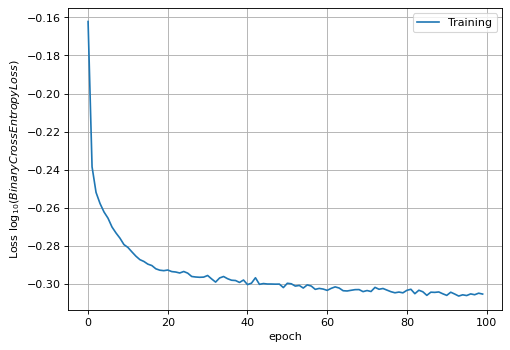

In [673]:
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(np.log10(history.history['loss']))
# plt.plot(np.log10(history.history['val_loss']))
#plt.title('model loss')
plt.ylabel(r'Loss $\log_{10}(Binary Cross Entropy Loss)$')
plt.xlabel('epoch')
plt.legend(['Training', 'Test'])
plt.grid()
plt.show()

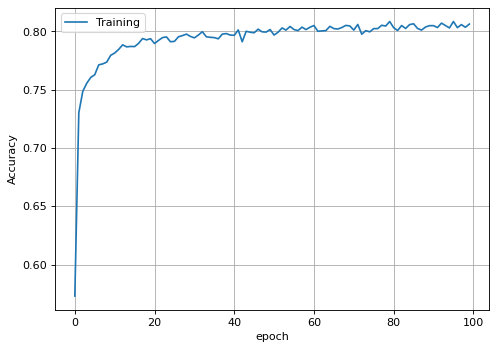

In [674]:
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
#plt.title('model loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Test'])
plt.grid()
plt.show()

## Tests de prédiction du NN sur les données d'entraînement

In [720]:
y_pred = tf.keras.layers.Softmax()(model.predict(train_features_nn_ar[1:100,:])).numpy()

In [721]:
y_true = train_labels_nn.values[1:100,:]

In [703]:
tf.keras.backend.argmax(train_labels_nn.values[50:70,:])

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
      dtype=int64)>

In [698]:
tf.keras.backend.argmax(model.predict(train_features_nn_ar[50:70,:]))

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
      dtype=int64)>

In [722]:
# mesurons la categorical binary entropy
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5771105>

## Tests de prédiction sur les données de test à submit
### Même traitement sur le test set que sur le train set pour l'entrée dans le réseau
On commence par convertir toutes les colonnes en `Float32` et ensuite on normalise les colonnes qui doivent l'être

In [678]:
test_features_nn = test_features.copy()

column_names_to_normalize = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Num']
normalize_input(test_features_nn, column_names_to_normalize)

for col_name in test_features_nn.columns:
    test_features_nn[col_name] = test_features_nn[col_name].astype('float32')
    
    
normalize_input(test_features_nn, column_names_to_normalize)

test_features_nn_ar = test_features_nn.to_numpy()

In [679]:
test_features_nn

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Num,Cabin_Side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0013_01,1.0,0.341772,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.001587,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0018_01,0.0,0.240506,0.0,0.000000,0.000356,0.00000,0.142260,0.000000,0.002116,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0019_01,1.0,0.392405,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0021_01,0.0,0.481013,0.0,0.000000,0.263206,0.00000,0.009121,0.026266,0.000529,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0023_01,0.0,0.253165,0.0,0.000865,0.000000,0.07658,0.000000,0.000000,0.002646,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,1.0,0.430380,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.791534,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9269_01,0.0,0.531646,0.0,0.000000,0.033514,0.00205,0.000504,0.006466,0.791534,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9271_01,1.0,0.531646,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.156614,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Predict & submit les prédictions du NN

In [686]:
predictions = model.predict(test_features_nn_ar)
distributions = tf.keras.layers.Softmax()(predictions)

In [688]:
distributions.numpy()

array([[0.59181446, 0.4081855 ],
       [0.880797  , 0.11920292],
       [0.11920294, 0.880797  ],
       ...,
       [0.12435611, 0.8756439 ],
       [0.15883377, 0.84116626],
       [0.12377638, 0.87622356]], dtype=float32)

In [691]:
transports = tf.keras.backend.argmax(distributions)

In [693]:
predict = pd.DataFrame(transports, index=input_test.index, columns=["Transported"])

In [694]:
predict.to_csv("./predict.csv")

In [695]:
!kaggle competitions submit -c spaceship-titanic -f "predict.csv" -m "SVM"

Successfully submitted to Spaceship Titanic



  0%|          | 0.00/46.0k [00:00<?, ?B/s]
 17%|#7        | 8.00k/46.0k [00:00<00:00, 53.1kB/s]
100%|##########| 46.0k/46.0k [00:01<00:00, 24.3kB/s]


# Visualiser toutes les features sans exception
On crée un DataFrame appelé `input_train_viz` conçu pour les visualisations spécialement

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   bool   
 1   Age                        8693 non-null   float64
 2   VIP                        8693 non-null   bool   
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   Transported                8693 non-null   bool   
 9   Cabin_Num                  8693 non-null   int64  
 10  Cabin_Side                 8693 non-null   bool   
 11  HomePlanet_Earth           8693 non-null   uint8  
 12  HomePlanet_Europa          8693 non-null   uint8  
 13  HomePlanet_Mars            8693 non-null   u

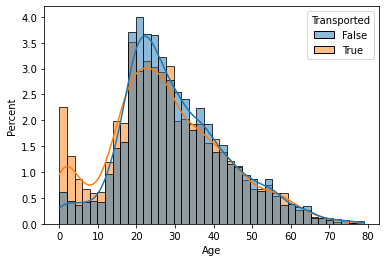

In [31]:
input_train_viz = input_train.drop(labels=['Name', 'Cabin'], axis=1)
input_train_viz = pd.get_dummies(input_train_viz) 
input_train_viz.info()

import seaborn as sns
sns.histplot(x='Age', data=input_train_viz, hue='Transported', bins=40, stat="percent", legend=True, kde=True)

for col_name in input_train_viz.columns:
    input_train_viz[col_name] = input_train_viz[col_name].astype('float32')

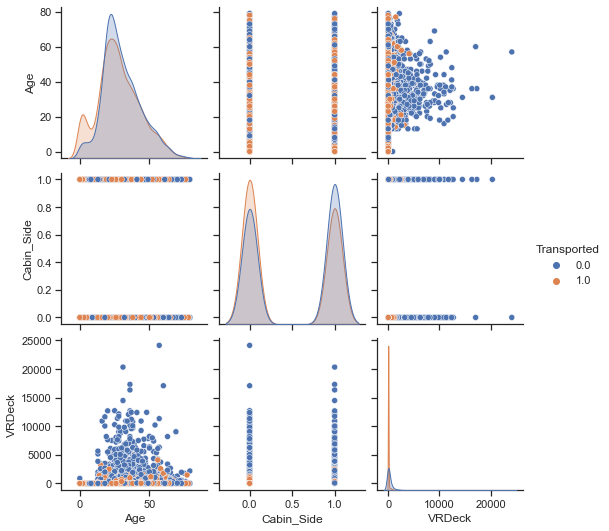

In [32]:
import seaborn as sns
sns.set_theme(style="ticks")

# sns.pairplot(input_train_viz.drop(labels=input_train_viz.columns[9:17], axis=1), hue="Transported")
sns.pairplot(input_train_viz.loc[:,["Age","Cabin_Side", "VRDeck", "Transported"]], hue="Transported")

## Faire une PCA des données et montrer quelles features sont prises en compte le plus
On normalise les données avant

In [33]:
import sklearn.preprocessing
std_scalar     = sklearn.preprocessing.StandardScaler()
min_max_scalar = sklearn.preprocessing.MinMaxScaler()

def normalize_input(df, col_to_norm):
    x = df[col_to_norm].values
    x_scaled = min_max_scalar.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=col_to_norm, index = df.index)
    df[col_to_norm] = df_temp

normalize_input(input_train_viz, input_train_viz.columns)


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
input_train_viz_ch = input_train_viz.drop(labels=["Transported"], axis=1)
input_train_viz_np = input_train_viz_ch.to_numpy()
pca.fit(input_train_viz_np)

PCA(n_components=2)

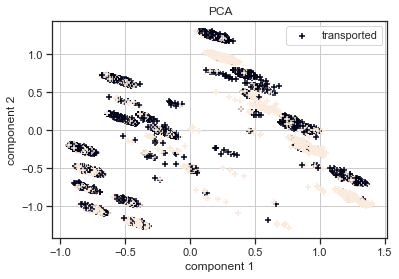

In [34]:
vect = pca.fit_transform(input_train_viz_np)
plt.scatter(vect[:,0], vect[:,1], c=input_train_viz['Transported'].to_numpy(), marker='+', label="transported")
plt.grid(True)
plt.title('PCA')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()

## Les 2 vecteurs propres qui discriminent les données le plus et leurs features associées

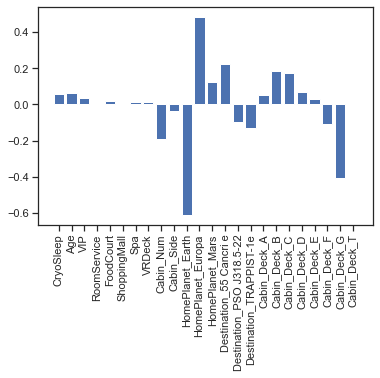

In [35]:
plt.bar(input_train_viz_ch.columns, pca.components_[0,:])
plt.xticks(rotation=90)
plt.show()

In [36]:
pca.explained_variance_

array([0.5419713, 0.4476889], dtype=float32)

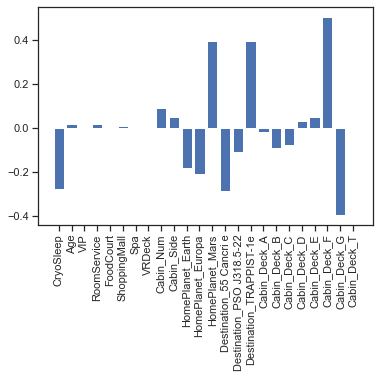

In [37]:
plt.bar(input_train_viz_ch.columns, pca.components_[1,:])
plt.xticks(rotation=90)
plt.show()

In [38]:
from sklearn.manifold import TSNE

In [39]:
tsne = TSNE(n_components=2, random_state=0, perplexity=15)
rd_flat_vect = tsne.fit_transform(input_train_viz_np)

C:\Users\matth\.conda\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\matth\.conda\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


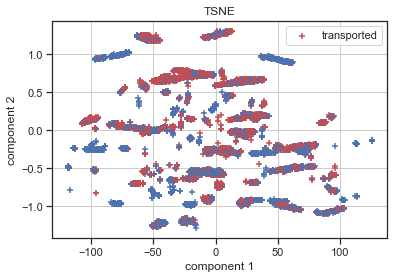

In [40]:
colormap = np.array(['r', 'b'])
categories = input_train_viz['Transported'].to_numpy().astype(int)

plt.scatter(rd_flat_vect[:,0], vect[:,1], c=colormap[categories], marker='+', label="transported")
plt.grid(True)
plt.title('TSNE')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()